In [38]:
import time
from scipy.sparse import vstack
from spacy_topic_model import TopicModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import json
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from alto_session import NAITM
from sklearn.metrics import accuracy_score
import sys, os
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
import pickle
from IPython.display import display
from tomotopy.utils import Corpus
from active_learning_session import LA


def blockPrint():
    sys.stdout = open(os.devnull, 'w')
    
def enablePrint():
    sys.stdout = sys.__stdout__

file_name = './Data/newsgroup_sub_500.json'
save_json_file_name = "./Data/{}_newsgroup_sub_500_data.json"
dataset_name = 'newsgroup_sub_500'
test_dataset_name = './Data/newsgroup_sub_1000.json'

In [2]:
df = pd.read_json(file_name)
print(len(np.unique(df['label'])))
actual_labels = df.label.values.tolist()
df.head(5)

20


,text,label
0,: : rangers top tenkwords: rangers: panix publ...,rec.sport.hockey
1,: intersc. bible search inst.: teme lines: 27 ...,soc.religion.christian
2,: : top 10 asons why i love cr (not for the ho...,rec.autos
3,subject: : amerins and evolutionfrom: halat@po...,alt.atheism
4,: frozen shoulder and lawn mowing: eastern ill...,sci.med


In [3]:
def train_models(path_name, num_topics):
    SLDA_model = TopicModel(corpus_path=path_name, model_type='SLDA', min_num_topics= 5, num_iters= 600, load_model=True, save_model=False, load_path='./Model/model_data.pkl', hypers = None)
    LLDA_model = TopicModel(corpus_path=path_name, model_type='LLDA', min_num_topics= 5, num_iters= 600, load_model=True, save_model=False, load_path='./Model/model_data.pkl', hypers = None)
    LDA_model = TopicModel(corpus_path=path_name, model_type='LDA', min_num_topics= 5, num_iters= 600, load_model=True, save_model=False, load_path='./Model/model_data.pkl', hypers = None)
    models = dict()
    models['SLDA'] = SLDA_model
    models['LLDA'] = LLDA_model
    models['LDA'] = LDA_model
#     model_topics = dict()
    
    for key, model in models.items():
        print('start {} model'.format(key))
        model.preprocess(5, 100);
        start = time.time()
        model.train(num_topics);
        end = time.time()
        print('Took {} seconds to prepare the model'.format(end-start))
#         model_topics[key] = model.print_topics();
        
    return models

In [4]:
def get_topic_probability(model_collection):
    doc_distribution = dict()
    for key, model in model_collection.items():
        doc_distribution[key] = dict()
        start = time.time()
        document_probas, doc_topic_probas = model.group_docs_to_topics()
        end = time.time()
        print('Took {} seconds to group the model'.format(end-start))
        
        doc_distribution[key]['document_probas'] = document_probas
        doc_distribution[key]['doc_topic_probas'] = doc_topic_probas
        
    return doc_distribution

In [17]:
def predict_labels(model_collection, model_type):
    inferred, _ = model_collection[model_type].lda_model.infer(model_collection[model_type].corpus)
    # print(inferred)
    preds = model_collection[model_type].lda_model.estimate(inferred)
    
    label_predictions = []
    for i, scores in enumerate(preds):
        topic_num = int(np.argmax(scores))
        label_predictions.append(model_collection[model_type].label_set[topic_num])
        
    return label_predictions

In [5]:
def get_accuracy(model_type, model_collection, document_data):
    result_df = model_collection[model_type].predict_labels(document_data)
    for k, v in result_df['topic_model_prediction_score'].items():
        result_df['topic_model_prediction_score'][k] = str(v)
        
    accuracy = sklearn.metrics.accuracy_score(result_df['label'], result_df['topic_model_prediction'])
    predicted_labels = result_df['topic_model_prediction']
    
    return accuracy, predicted_labels

In [6]:
def map_labels(model_type, model_collection, labels):
    simple_label_map = dict()

    unique_set = model_collection[model_type].label_set
    for i in range(len(unique_set)):
        simple_label_map[unique_set[i]] = i
        
    map_labels = []

    for ele in labels:
        map_labels.append(simple_label_map[ele])
    
    return simple_label_map, map_labels

def vectorize_texts(input_texts):
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
    vectorizer_idf = vectorizer.fit_transform(input_texts)
    
    return vectorizer_idf

def get_reverse_topics(model_type, model_collection):
    if model_type == 'LDA':
        simple_label_map, LDA_map_labels = map_labels(model_type, model_collection, model_collection[model_type].labels)
        return simple_label_map
    
    topics = model_collection[model_type].print_topics(verbose=False)
    
    topic_map = dict()
    for k, v in topics.items():
        topic_map[k] = v[1]

    reverse_topic_map = dict()
    for k, v in topics.items():
        reverse_topic_map[v[1]] = k
        
    return reverse_topic_map

In [52]:
def concatenate_input_vectorizer(model_collection, model_type, document_data):        
    LDA_df = model_collection[model_type].predict_labels(document_data)
    for k, v in LDA_df['topic_model_prediction_score'].items():
        LDA_df['topic_model_prediction_score'][k] = str(v)
    
    save_json_file_name = './Data/{}_concatenated_input.json'
    with open(save_json_file_name.format(model_type), "w") as outfile:
        json.dump(LDA_df,outfile)
    
    prediction_df = pd.read_json(save_json_file_name.format(model_type))
    
    doc_keywords = prediction_df['topic_keywords']
    doc_words_only = [ele.replace(',', '') for ele in doc_keywords]
    
    filtered_texts = [' '.join(ele) for ele in model_collection[model_type].data_words_nonstop]

    contatenated_texts = [filtered_texts[i] + '' + doc_words_only[i] for i in range(len(filtered_texts))]
        
    return contatenated_texts

def concatenate_unseen_vectorizer(model_collection, model_type, document_data, processed_texts):
#     documents = document_data.text.values.tolist()
    # doc_key_words = [model_collection[model_type].predict_new_doc(doc)[1] for doc in processed_texts]
    test_corpus = Corpus()
    for doc in processed_texts:
        test_corpus.add_doc(model_collection[model_type].lda_model.make_doc(doc))
        
    # test_datas = [model_collection[model_type] for doc in pre_processing_texts]
    # model_predictions = model_collection[model_type].predict
    
    if model_type == 'SLDA':
        inferred, _ = model_collection[model_type].lda_model.infer(test_corpus)
        preds = model_collection[model_type].lda_model.estimate(inferred)
    else:
        preds, _ = model_collection[model_type].lda_model.infer(test_corpus)

    doc_key_words = []
    for i, scores in enumerate(preds):
        if model_type == 'SLDA':
            topic_num = int(np.argmax(scores))
            topic_words = ' '.join([tup[0] for tup in model_collection[model_type].lda_model.get_topic_words(topic_num, top_n=10)])
            doc_key_words.append(topic_words)
        else:
            topic_num, topic_pct = scores.get_topics(top_n=1)[0]
            topic_words = ' '.join([tup[0] for tup in model_collection[model_type].lda_model.get_topic_words(topic_num, top_n=10)])
            doc_key_words.append(topic_words)
    
    filtered_texts = [' '.join(ele) for ele in processed_texts]
    # doc_words_only = [''.join(ele) for ele in doc_key_words]
    
    contatenated_texts = [filtered_texts[i] + ' ' + doc_key_words[i] for i in range(len(filtered_texts))]
#     print(contatenated_texts[1])
    
    return contatenated_texts

In [9]:
def pre_processing_texts(corpus_data_path):
    print('Processing data...')
    dataframe = pd.read_json(corpus_data_path)
    data = dataframe.text.values.tolist()
    data_words_nonstop = []
    # print('Finish lemmatization')

    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('sentencizer')
                            
    docs = [nlp(x) for x in data]
    stop_words = STOP_WORDS
    
    with open("newsgroup_removewords.txt") as f:
        words_to_remove = f.readlines()
            
    words_to_remove = [x.strip() for x in words_to_remove]
    new_words_to_remove = [j.replace('\'', '') for i in words_to_remove for j in i.split(',')]
    new_words_to_remove = [j.replace(' ', '') for j in new_words_to_remove]
    # self.stop_words.extend(new_words_to_remove)
    for word in new_words_to_remove:
        stop_words.add(word)
    
    print('not')
    print('not' in stop_words)
    #Creating and updating our list of tokens using list comprehension 
    if 'newsgroup' in corpus_data_path:
        for doc in docs:
            temp_doc = []
            
            for token in doc:
                if not len(str(token)) == 1 and (re.search('[a-z0-9]+',str(token))) \
                    and not token.pos_ == 'PROPN' and not token.is_digit and not token.is_space \
                    and str(token).lower() not in stop_words:
                    temp_doc.append(token.lemma_)
                    
            data_words_nonstop.append(temp_doc)
                    
    else:
        for doc in docs:
            temp_doc = []
            for token in doc:
                if (re.search('[a-z0-9]+',str(token))) \
                    and not len(str(token)) == 1 and not token.is_digit and not token.is_space \
                    and str(token).lower() not in stop_words:
                        temp_doc.append(token.lemma_)
            
            data_words_nonstop.append(temp_doc)
            
    return data_words_nonstop

In [10]:
def simulate_experiment(model_collection, model_type, model_topic_distribution, dataframe, test_path, break_down_test_size, input_vectorizer):
    topics = model_collection[model_type].print_topics(verbose=False)
    test_df = pd.read_json(test_path)
    
    '''
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
    token_lst = concatenate_input_vectorizer(model_collection[model_type].data_words_nonstop, model_collection, model_type, topics)
    input_vectorizer = vectorizer.fit_transform(token_lst)
    '''
    
#     test_texts = test_df['text']
    test_labels = test_df['label']
    
    gold_labels = dataframe.label.values.tolist()
    unique_labels = np.unique(gold_labels)
    
    simple_label_map = {i:unique_labels[i] for i in range(len(unique_labels))}
    reverse_label_mapping = {v:k for k, v in simple_label_map.items()}
    test_map_labels = [reverse_label_mapping[ele] for ele in test_labels]

    
    session = NAITM(model_collection[model_type].get_texts(), model_topic_distribution[model_type]['document_probas'],  model_topic_distribution[model_type]['doc_topic_probas'], dataframe, 'logreg', input_vectorizer, len(topics), 500)
    
    
    doc_count = 0
    doc_recommend_score = []
    lst = []

    classifier_acc = []
    recommend_ids1, actual_topic1 = [], []

    test_acc1 = dict()
    for ele in break_down_test_size:
        test_acc1[ele] = []

    # logreg_model3 = SGDClassifier(loss="log", penalty="l2", max_iter=1000, tol=1e-3, random_state=42, learning_rate="adaptive", eta0=0.1, validation_fraction=0.2)
    start_time = time.time()
    while doc_count < 500:
        try:
            random_document, score = session.recommend_document();
        except:
            print('reached the end of the experiment. {} docs labeled'.format(doc_count))
            end_time = time.time()
            break

            
        inferred_topics = gold_labels[random_document]


        if doc_count >= 3:
            logreg_y_pred= session.classifier.predict(input_vectorizer[0:500])



            accuracy = accuracy_score(test_map_labels[0:500], logreg_y_pred)
            print('classifier accuracy is {}'.format(accuracy))
            for j in break_down_test_size:
        #         print(j)
                test_logreg_y_pred= session.classifier.predict(input_vectorizer[500:j])
                test_accuracy = accuracy_score(test_map_labels[500:j], test_logreg_y_pred)
                test_acc1[j].append(test_accuracy)

            print('test set acc {}'.format(test_acc1[800][-1]))
            '''
            Save this part
            '''
            classifier_acc.append(accuracy)
            doc_recommend_score.append(score)
        else:
            classifier_acc.append(-1)
            doc_recommend_score.append(-1)
            for j in break_down_test_size:
                test_acc1[j].append(-1)

        '''
        remember to also save recommended document id and inferred topics
        '''
        recommend_ids1.append(random_document)
        
        actual_topic1.append(reverse_label_mapping[gold_labels[random_document]])

        print('document id {}'.format(random_document))
        print('inferred topics are {}'.format(inferred_topics))
        print('\033[1mactual label is {}\033[0m'.format(model_collection[model_type].labels[random_document]))
    #     session.label(random_document, user_input)
    #     print('\033[1mpredicted topic is {}\033[0m'.format(reverse_SLDA_topic_map[slda_predicted[random_document]]))
        print('\033[1mgold topic is {}\033[0m'.format(reverse_label_mapping[gold_labels[random_document]]))

    #     session.label(random_document, reverse_SLDA_topic_map[slda_predicted[random_document]])
        session.label(random_document, reverse_label_mapping[gold_labels[random_document]])

    #     logreg_y_pred= .predict(vectorizer_idf)

        lst.append(doc_count)
        
        if doc_count % 7 == 0 and model_type == 'SLDA':
            model_collection[model_type].retrain()
        
        doc_count += 1
        end_time = time.time()
    
    result = pd.DataFrame()
    result['classifier acc'] = classifier_acc
    result['actual topic'] = actual_topic1
    result['recommend ids'] = recommend_ids1
    result['recommend score'] = doc_recommend_score

    for k, v in test_acc1.items():
        result['{} test set'.format(k-500)] = v
    
    result.to_csv('./Data/{}_concatenate_result.csv'.format(model_type), index=False)
    
    return result, end_time-start_time

In [11]:
def simulate_baseline_experiment(dataframe, test_path, break_down_test_size, input_vectorizer, gold_labels):
    test_df = pd.read_json(test_path)
    
    test_labels = test_df['label']
    unique_labels = np.unique(gold_labels)
    
    simple_label_map = {i:unique_labels[i] for i in range(len(unique_labels))}
    reverse_label_mapping = {v:k for k, v in simple_label_map.items()}
    test_map_labels = [reverse_label_mapping[ele] for ele in test_labels]
    
    
    print(simple_label_map)
    document_texts = dataframe.text.values.tolist()
    result_actual_labels = []
    session = LA(document_texts, dataframe, 'logreg', input_vectorizer, 500)
    
    doc_count = 0
    doc_recommend_score = []
    lst = []
    acc= []
    document_stack, labels_track = None, []
    classifier_acc = []
    recommend_ids1 = []

    test_acc1 = dict()
    for ele in break_down_test_size:
        test_acc1[ele] = []

    # logreg_model3 = SGDClassifier(loss="log", penalty="l2", max_iter=1000, tol=1e-3, random_state=42, learning_rate="adaptive", eta0=0.1, validation_fraction=0.2)
    start_time = time.time()
    
    while doc_count < 500:
        try:
            random_document, score = session.recommend_document();
        except:
            print('reached the end of the experiment. {} docs labeled'.format(doc_count))
            end_time = time.time()
            break
        
    #     inferred_topics = models['SLDA'].predict_doc(random_document, 3);

    #     inferred_topics = slda_predicted[random_document]
        inferred_topics = gold_labels[random_document]
        result_actual_labels.append(inferred_topics)

        if doc_count >= 3:
            logreg_y_pred= session.classifier.predict(input_vectorizer[0:500])



            accuracy = accuracy_score(test_map_labels[0:500], logreg_y_pred)

            for j in break_down_test_size:
        #         print(j)
                test_logreg_y_pred= session.classifier.predict(input_vectorizer[500:j])
                test_accuracy = accuracy_score(test_map_labels[500:j], test_logreg_y_pred)
                test_acc1[j].append(test_accuracy)

            print('test set acc {}'.format(test_acc1[800][-1]))
            '''
            Save this part
            '''
            classifier_acc.append(accuracy)
            doc_recommend_score.append(score)
            print('classifier accuracy is {}'.format(accuracy))
        else:
            classifier_acc.append(-1)
            doc_recommend_score.append(-1)
            for j in break_down_test_size:
                test_acc1[j].append(-1)

        '''
        remember to also save recommended document id and inferred topics
        '''
        recommend_ids1.append(random_document)


        print('document id {}'.format(random_document))
        print('actual label is {}'.format(inferred_topics))
        
       

        session.label(random_document, reverse_label_mapping[gold_labels[random_document]])


        lst.append(doc_count)
        
        
        doc_count += 1
        end_time = time.time()
    
    result = pd.DataFrame()
    result['classifier acc'] = classifier_acc
#     result['inferred topic'] = model_inferred_topics1
    result['actual label'] = result_actual_labels
    result['recommend ids'] = recommend_ids1
    result['recommend score'] = doc_recommend_score

    for k, v in test_acc1.items():
        result['{} test set'.format(k-500)] = v
    
    result.to_csv('./Data/baseline_result.csv', index=False)
    
    return result, end_time-start_time

# This section runs an experiment

In [12]:
# blockPrint()
experiment_models = train_models(file_name, 20);

start SLDA model
num topics: 20
Created SLDA model
starting training...
Took 18.666397094726562 seconds to prepare the model
start LLDA model
num topics: 20
Created LLDA model
starting training...
Took 1.7921907901763916 seconds to prepare the model
start LDA model
num topics: 20
Created LDA model
starting training...
Took 1.7590200901031494 seconds to prepare the model


In [13]:
enablePrint()
experiment_topic_distribution = get_topic_probability(experiment_models)

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
# experiment_vectorizer_idf = vectorizer.fit_transform(pd.read_json(test_dataset_name)['text'])
# processed_data = pre_processing_texts(test_dataset_name)
SLDA_experiment_vectorizer_idf = concatenate_input_vectorizer(experiment_models, 'SLDA', df)
SLDA_experiment_vectorizer_idf = vectorizer.fit_transform(SLDA_experiment_vectorizer_idf)
experiment_vectorizer_idf = vectorizer.fit_transform(pd.read_json(test_dataset_name)['text'])

In [15]:
experiment_test_sizes = [i for i in range(len(pd.read_json(test_dataset_name)['text']) + 1) if i > 500 and i % 100 == 0]

In [18]:
# Check the accuracy rate of sLDA
sLDA_pred = predict_labels(experiment_models, 'SLDA')
display(sklearn.metrics.accuracy_score(experiment_models['SLDA'].labels, sLDA_pred))

0.51

In [26]:
# SLDA_experiment_result, SLDA_experiment_time = simulate_experiment(experiment_models, 'SLDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, SLDA_experiment_vectorizer_idf)

In [17]:
LLDA_experiment_vectorizer_idf = concatenate_input_vectorizer(experiment_models, 'LLDA', df)
LLDA_experiment_vectorizer_idf = vectorizer.fit_transform(LLDA_experiment_vectorizer_idf)
LLDA_experiment_result, LLDA_experiment_time = simulate_experiment(experiment_models, 'LLDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, LLDA_experiment_vectorizer_idf)

In [14]:
LDA_experiment_vectorizer_idf = concatenate_input_vectorizer(experiment_models, 'LDA', df)
LDA_experiment_vectorizer_idf = vectorizer.fit_transform(LDA_experiment_vectorizer_idf)
LDA_experiment_result, LDA_experiment_time = simulate_experiment(experiment_models, 'LDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, LDA_experiment_vectorizer_idf)

# Plotting results

In [27]:
from plotnine import *
def plot(data, xlabel, ylabel, title):
    data_long = pd.melt(data, id_vars=['k'], var_name='model', value_name='perplexity')

    # Create line plot
    return ggplot(data_long, aes(x='k', y='perplexity', color='model', group='model')) \
        + geom_line() \
        + xlab(xlabel) \
        + ylab(ylabel) \
        + ggtitle(title) \
        + theme_minimal()
    
    

In [28]:
save = False

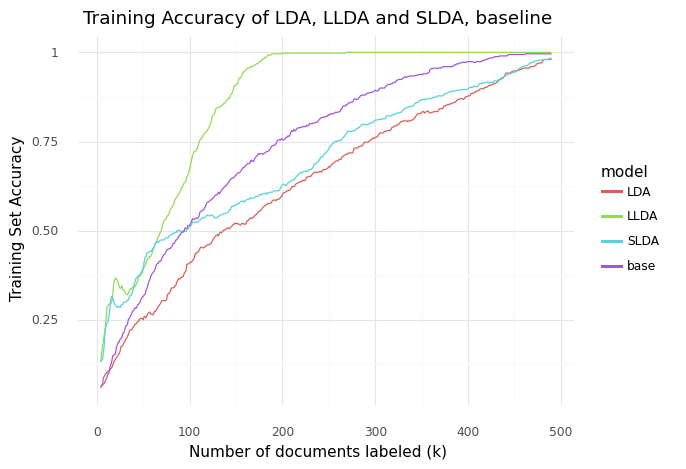

<ggplot: (8791475210885)>

In [35]:
SLDA_experiment_acc = SLDA_experiment_result['classifier acc']
LLDA_experiment_acc = LLDA_experiment_result['classifier acc']
LDA_experiment_acc = LDA_experiment_result['classifier acc']
baseline_experiment_acc = baseline_result['classifier acc']

lst_len = min(len(SLDA_experiment_acc), len(LLDA_experiment_acc), len(LDA_experiment_acc), len(baseline_experiment_acc))

# Create data frame from the given data
data = pd.DataFrame({
    'k': [i for i in range(4, lst_len)],
    'LLDA': LLDA_experiment_acc[4:lst_len],
    'SLDA': SLDA_experiment_acc[4:lst_len],
    'LDA': LDA_experiment_acc[4:lst_len],
    'base': baseline_experiment_acc[4:lst_len]
})

plot_res = plot(data, 'Number of documents labeled (k)', 'Training Set Accuracy', 'Training Accuracy of LDA, LLDA and SLDA, baseline')
if save:
    ggsave(plot_res,file='Training_accuracy.png')
plot_res

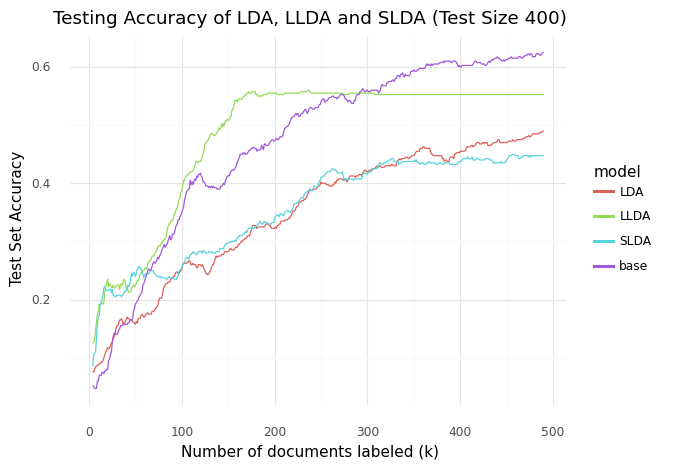

<ggplot: (8791353263025)>

In [36]:
SLDA_experiment_test_acc = SLDA_experiment_result['400 test set']
LLDA_experiment_test_acc = LLDA_experiment_result['400 test set']
LDA_experiment_test_acc = LDA_experiment_result['400 test set']
baseline_experiment_test_acc = baseline_result['400 test set']

# Create data frame from the given data
data = pd.DataFrame({
    'k': [i for i in range(4, lst_len)],
    'LLDA': LLDA_experiment_test_acc[4:lst_len],
    'SLDA': SLDA_experiment_test_acc[4:lst_len],
    'LDA': LDA_experiment_test_acc[4:lst_len],
    'base': baseline_experiment_test_acc[4:lst_len]
})

plot_res1 = plot(data, 'Number of documents labeled (k)', 'Test Set Accuracy', 'Testing Accuracy of LDA, LLDA and SLDA (Test Size 400)')
if save:
    ggsave(plot_res1,file='Testing_accuracy_400.png')
plot_res1

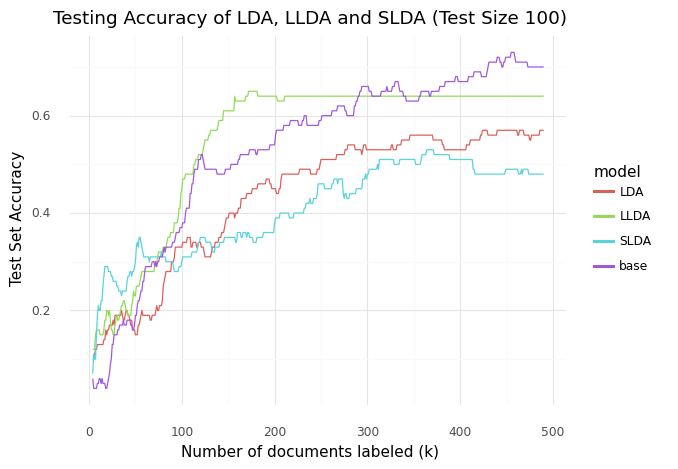

<ggplot: (8791349847977)>

In [37]:
# Create data frame from the given data
data = pd.DataFrame({
    'k': [i for i in range(4, lst_len)],
    'LLDA': LLDA_experiment_result['100 test set'][4:lst_len],
    'SLDA': SLDA_experiment_result['100 test set'][4:lst_len],
    'LDA': LDA_experiment_result['100 test set'][4:lst_len],
    'base': baseline_result['100 test set'][4:lst_len]
})

plot_res2 = plot(data, 'Number of documents labeled (k)', 'Test Set Accuracy', 'Testing Accuracy of LDA, LLDA and SLDA (Test Size 100)')
if save:
    ggsave(plot_res2,file='Testing_accuracy_150.png')
plot_res2

# Run the experiment when only using the training set in the LDA models

In [40]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2))
# experiment_vectorizer_idf = vectorizer.fit_transform(pd.read_json(test_dataset_name)['text'])
test_df = pd.read_json(test_dataset_name)

if os.path.exists(test_dataset_name.replace('.json', '.pkl')):
     with open(test_dataset_name.replace('.json', '.pkl'), 'rb') as inp:
        processed_data = pickle.load(inp)
else:
    processed_data = pre_processing_texts(test_dataset_name)
# concatenate_unseen_vectorizer(model_collection, model_type, document_data, processed_texts)

### Code to save the data. If not saving data, then need to process the data

In [21]:
# test_dataset_name = './Data/newsgroup_sub_1000.json'
with open(test_dataset_name.replace('.json', '.pkl'), 'wb+') as outp:
    pickle.dump(processed_data, outp)

### Perform the experiment

In [53]:
SLDA_experiment_vectorizer_idf = concatenate_unseen_vectorizer(experiment_models, 'SLDA', test_df, processed_data)
SLDA_experiment_vectorizer_idf = vectorizer.fit_transform(SLDA_experiment_vectorizer_idf)

In [54]:
SLDA_experiment_result, SLDA_experiment_time = simulate_experiment(experiment_models, 'SLDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, SLDA_experiment_vectorizer_idf)

In [55]:
LLDA_experiment_vectorizer_idf = concatenate_unseen_vectorizer(experiment_models, 'LLDA', test_df, processed_data)
LLDA_experiment_vectorizer_idf = vectorizer.fit_transform(LLDA_experiment_vectorizer_idf)
LLDA_experiment_result, LLDA_experiment_time = simulate_experiment(experiment_models, 'LLDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, LLDA_experiment_vectorizer_idf)

In [56]:
LDA_experiment_vectorizer_idf = concatenate_unseen_vectorizer(experiment_models, 'LDA', test_df, processed_data)
LDA_experiment_vectorizer_idf = vectorizer.fit_transform(LDA_experiment_vectorizer_idf)
LDA_experiment_result, LDA_experiment_time = simulate_experiment(experiment_models, 'LDA', experiment_topic_distribution, df, test_dataset_name, experiment_test_sizes, LDA_experiment_vectorizer_idf)

In [51]:
# simulate_baseline_experiment(dataframe, test_path, break_down_test_size, input_vectorizer, gold_labels)
baseline_result, baseline_time = simulate_baseline_experiment(df, test_dataset_name, experiment_test_sizes, experiment_vectorizer_idf, df.label.values.tolist())